In [1]:
import tensorflow as tf
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization,Activation
from keras.utils import to_categorical

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

C:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import os
import cv2
from PIL import Image

In [4]:
from keras import backend as K

In [5]:
parasitized=os.listdir('cell_images/Parasitized')
uninfected=os.listdir('cell_images/Uninfected')

In [6]:
data=[]
labels=[]

for a in parasitized:
    try:
        image=cv2.imread("cell_images/Parasitized/"+a)
        image_from_array=Image.fromarray(image,'RGB')
        size_image=image_from_array.resize((50,50))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")
  

In [7]:
for b in uninfected:
    try:
        image=cv2.imread("cell_images/Uninfected/"+b)
        image_from_array=Image.fromarray(image,'RGB')
        size_image=image_from_array.resize((50,50))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

In [8]:
cells = np.array(data)
labels = np.array(labels)

np.save('Cells' , cells)
np.save('Labels' , labels)

In [9]:
print('Cells : {} | labels : {}'.format(cells.shape , labels.shape))

Cells : (27558, 50, 50, 3) | labels : (27558,)


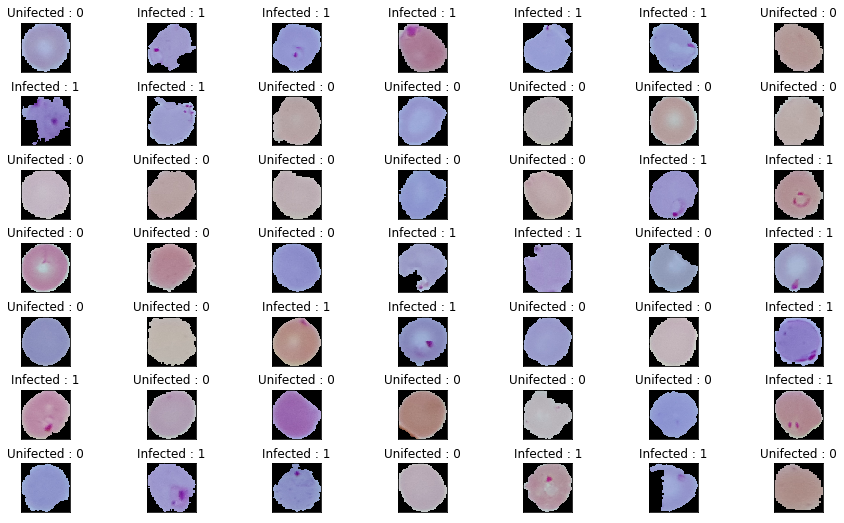

In [10]:
plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint(0 , cells.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(cells[r[0]])
    plt.title('{} : {}'.format('Infected' if labels[r[0]] == 1 else 'Unifected' ,
                               labels[r[0]]) )
    plt.xticks([]) , plt.yticks([])
    
plt.show()

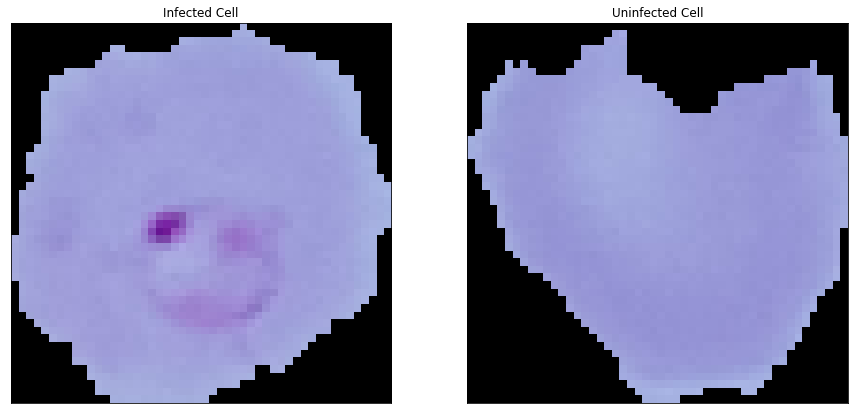

In [11]:
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
plt.imshow(cells[0])
plt.title('Infected Cell')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 2 , 2)
plt.imshow(cells[14000])
plt.title('Uninfected Cell')
plt.xticks([]) , plt.yticks([])

plt.show()

In [12]:
n = np.arange(cells.shape[0])
np.random.shuffle(n)
cells = cells[n]
labels = labels[n]

In [35]:
from sklearn.model_selection import train_test_split

train_x , x , train_y , y = train_test_split(cells , labels , 
                                            test_size = 0.2 ,
                                            random_state = 111)

eval_x , test_x , eval_y , test_y = train_test_split(x , y , 
                                                    test_size = 0.5 , 
                                                    random_state = 111)

In [36]:
img_rows=50
img_cols=50
num_classes=2
epochs = 10
batch_size = 128

In [37]:
if K.image_data_format() == 'channels_first':
    train_x = train_x.reshape(train_x.shape[0], 3, img_rows, img_cols)
    test_x = test_x.reshape(test_x.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    train_x = train_x.reshape(train_x.shape[0], img_rows, img_cols, 3)
    eval_x = eval_x.reshape(eval_x.shape[0], img_rows, img_cols, 3)
    test_x = test_x.reshape(test_x.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

In [38]:
train_x = train_x.astype('float32')
test_x = test_x.astype('float32')
eval_x=eval_x.astype('float32')
train_x /= 255
test_x /= 255
eval_x/=255
print('x_train shape:', train_x.shape)
print(train_x.shape[0], 'train samples')
print(test_x.shape[0], 'test samples')
print(eval_x.shape[0],'validation samples')

x_train shape: (22046, 50, 50, 3)
22046 train samples
2756 test samples
2756 validation samples


In [40]:
test_y1=test_y
test_y1

array([1, 1, 1, ..., 1, 0, 1])

In [41]:
# convert class vectors to binary class matrices
train_y = keras.utils.to_categorical(train_y, 2)
test_y = keras.utils.to_categorical(test_y, 2)
eval_y = keras.utils.to_categorical(eval_y, 2)

In [42]:
num_classes=len(np.unique(labels))
num_classes

2

In [43]:
train_y.shape

(22046, 2)

In [44]:
train_y[0]

array([1., 0.])

### Model-1: 5*5 kernel

In [46]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(60,(5,5),activation='relu'))
model.add(Dropout(0.25))
model.add(Conv2D(94, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(5, 5)))
model.add(Dropout(0.25))
model.add(Flatten())


model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history=model.fit(train_x, train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(eval_x, eval_y))
score = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 22046 samples, validate on 2756 samples
Epoch 1/10
22046/22046 [==============================] - 16s 743us/step - loss: 0.6958 - acc: 0.5530 - val_loss: 0.6737 - val_acc: 0.5744
Epoch 2/10
22046/22046 [==============================] - 16s 704us/step - loss: 0.5887 - acc: 0.6886 - val_loss: 0.4225 - val_acc: 0.8211
Epoch 3/10
22046/22046 [==============================] - 16s 711us/step - loss: 0.2731 - acc: 0.8886 - val_loss: 0.3519 - val_acc: 0.8451
Epoch 4/10
22046/22046 [==============================] - 17s 750us/step - loss: 0.1847 - acc: 0.9369 - val_loss: 0.1781 - val_acc: 0.9448
Epoch 5/10
22046/22046 [==============================] - 16s 744us/step - loss: 0.1562 - acc: 0.9483 - val_loss: 0.1704 - val_acc: 0.9441
Epoch 6/10
22046/22046 [==============================] - 16s 742us/step - loss: 0.1501 - acc: 0.9506 - val_loss: 0.1539 - val_acc: 0.9474
Epoch 7/10
22046/22046 [==============================] - 16s 741us/step - loss: 0.1432 - acc: 0.9516 - val_loss: 0.1

In [47]:
def plot_loss_acc_curves(history):
# Loss Curves
  plt.figure(figsize=[8,6])
  plt.plot(history.history['loss'],'r',linewidth=3.0)
  plt.plot(history.history['val_loss'],'b',linewidth=3.0)
  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)
# Accuracy Curves 
  plt.figure(figsize=[8,6])
  plt.plot(history.history['acc'],'r',linewidth=3.0)
  plt.plot(history.history['val_acc'],'b',linewidth=3.0)
  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)

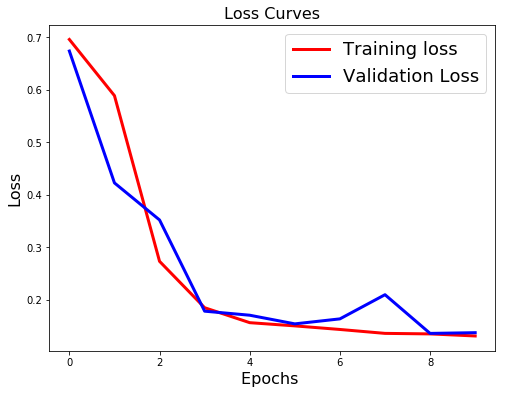

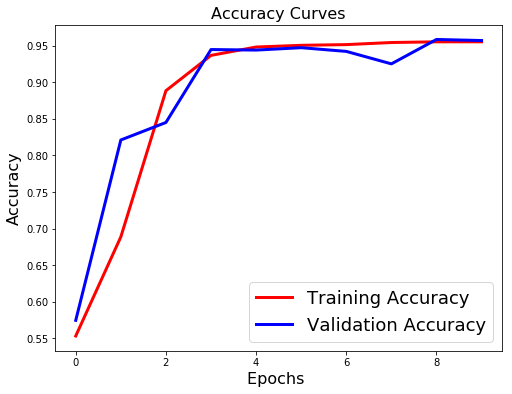

In [48]:
plot_loss_acc_curves(history)

In [49]:
import h5py

In [50]:
from keras.models import load_model

In [51]:
model.save('my_model_1CNN.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

In [52]:
# returns a compiled model
# identical to the previous one
model = load_model('my_model_1CNN.h5')

In [53]:
classes=model.predict_classes(test_x,batch_size=128)

In [54]:
classes

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

In [55]:
test_y1

array([1, 1, 1, ..., 1, 0, 1])

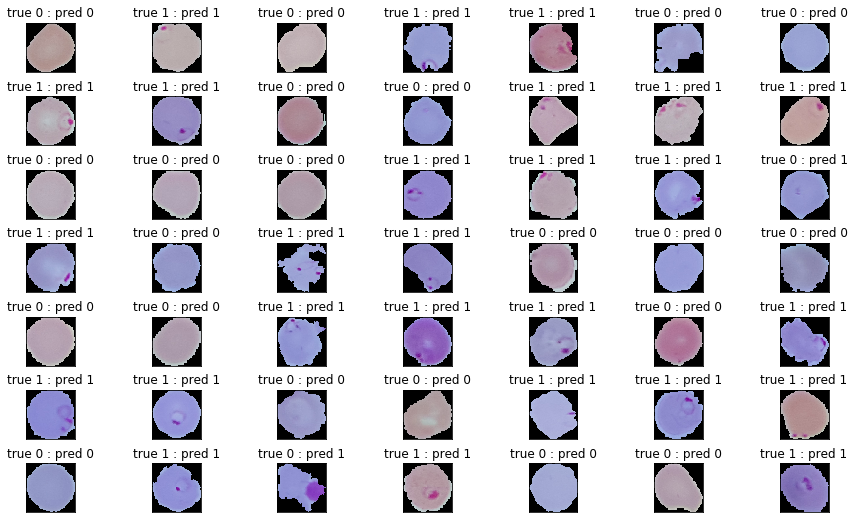

In [56]:
plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint( 0  , test_x.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(test_x[r[0]])
    plt.title('true {} : pred {}'.format(test_y1[r[0]] , classes[r[0]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()

### 7-layer Convo

### 5*5 kernel

In [57]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=input_shape))

model.add(Conv2D(60,(5,5),activation='relu'))
model.add(Dropout(0.25))

model.add(Conv2D(80, (5, 5), activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv2D(90,(5,5),activation='relu'))
model.add(Dropout(0.25))

model.add(Conv2D(100,(5,5),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Dropout(0.25))
model.add(Conv2D(110,(5,5),activation='relu',padding='same'))


model.add(Dropout(0.25))
model.add(Conv2D(120,(5,5),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3)))


model.add(Flatten())


model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history=model.fit(train_x, train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(eval_x,eval_y))
score = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 22046 samples, validate on 2756 samples
Epoch 1/10
22046/22046 [==============================] - 39s 2ms/step - loss: 0.6657 - acc: 0.6421 - val_loss: 0.8853 - val_acc: 0.5323
Epoch 2/10
22046/22046 [==============================] - 35s 2ms/step - loss: 0.3684 - acc: 0.8515 - val_loss: 0.2233 - val_acc: 0.9260
Epoch 3/10
22046/22046 [==============================] - 34s 2ms/step - loss: 0.1981 - acc: 0.9359 - val_loss: 0.2298 - val_acc: 0.9285
Epoch 4/10
22046/22046 [==============================] - 34s 2ms/step - loss: 0.1680 - acc: 0.9472 - val_loss: 0.1897 - val_acc: 0.9427
Epoch 5/10
22046/22046 [==============================] - 37s 2ms/step - loss: 0.1556 - acc: 0.9495 - val_loss: 0.3842 - val_acc: 0.7812
Epoch 6/10
22046/22046 [==============================] - 33s 1ms/step - loss: 0.1502 - acc: 0.9495 - val_loss: 0.1274 - val_acc: 0.9601
Epoch 7/10
22046/22046 [==============================] - 34s 2ms/step - loss: 0.1411 - acc: 0.9543 - val_loss: 0.1469 - val_acc:

In [58]:
model.save('my_model_2CNN.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

In [59]:
# returns a compiled model
# identical to the previous one
model = load_model('my_model_2CNN.h5')

In [60]:
classes=model.predict_classes(test_x,batch_size=128)

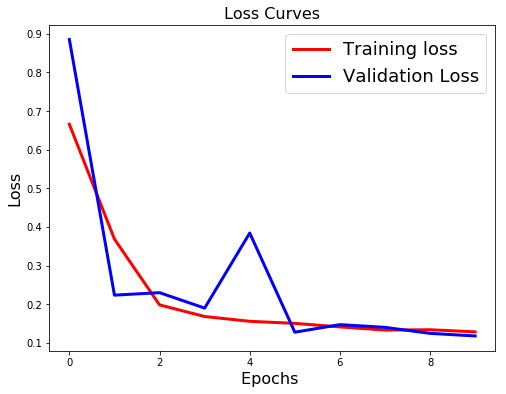

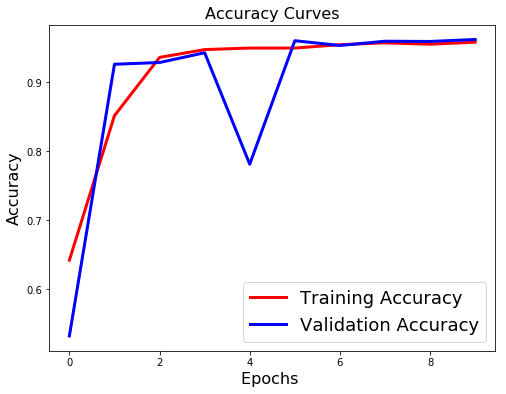

In [62]:
plot_loss_acc_curves(history)

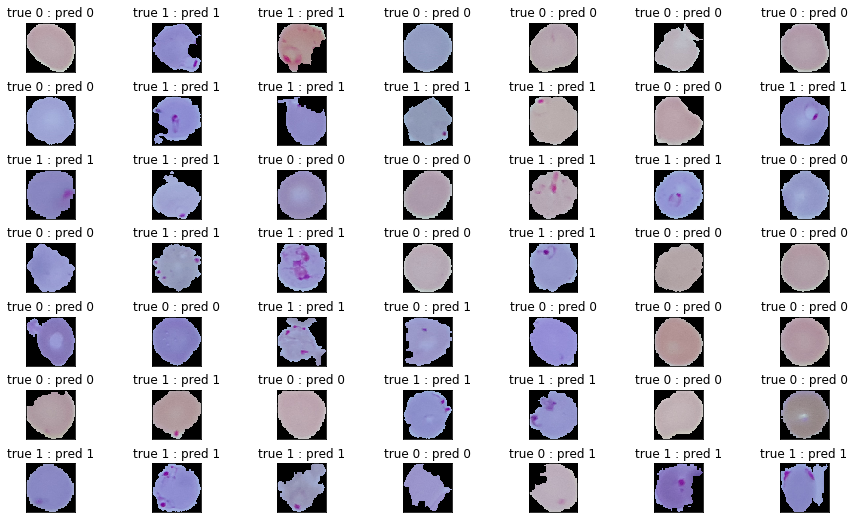

In [61]:
plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint( 0  , test_x.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(test_x[r[0]])
    plt.title('true {} : pred {}'.format(test_y1[r[0]] , classes[r[0]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()